In [6]:
# Config: change these if your local path differs.
BASE_DIR = r"C:\Users\Admin\Desktop\UNSW\9517\project\mL"
DATASET_ROOT = BASE_DIR + "\\archive" # where train/ valid/ test folders are
TRAIN_IMG_DIR = DATASET_ROOT + "\\train\\images"
TRAIN_LABEL_DIR = DATASET_ROOT + "\\train\\labels"
VALID_IMG_DIR = DATASET_ROOT + "\\valid\\images"
VALID_LABEL_DIR = DATASET_ROOT + "\\valid\\labels"
DATA_YAML = DATASET_ROOT + "\\data.yaml"


# Where we write organized data, features, models, results
OUT_DIR = BASE_DIR + "\\data" # organized by class
FEATURE_DIR = BASE_DIR + "\\features"
MODEL_DIR = BASE_DIR + "\\models"
RESULT_DIR = BASE_DIR + "\\results"


# Quick-run options
SAMPLE_LIMIT = None # set to integer (e.g. 2000) to debug quickly; or None for full data
IMG_SIZE = (128, 128) # resize for feature extraction
RANDOM_STATE = 42

In [7]:
# 1. 导入库并创建输出目录
# 说明：这一步检查环境并创建需要的文件夹。
# Import libs and create folders
import os, glob, shutil
import yaml
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import joblib
import cv2
from skimage.feature import hog, local_binary_pattern
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
confusion_matrix, roc_auc_score, roc_curve)


os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(FEATURE_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(RESULT_DIR, exist_ok=True)


print("Base dir:", BASE_DIR)
print("Dataset root:", DATASET_ROOT)

Base dir: C:\Users\Admin\Desktop\UNSW\9517\project\mL
Dataset root: C:\Users\Admin\Desktop\UNSW\9517\project\mL\archive


In [8]:
!pip install tqdm

In [9]:
# ## 3️⃣ 读取类别名
if os.path.exists(DATA_YAML):
    with open(DATA_YAML, 'r') as f:
        cfg = yaml.safe_load(f)
    NAMES = cfg.get('names')
else:
    NAMES = [f'class_{i}' for i in range(12)]
print(f"共 {len(NAMES)} 类:", NAMES)

共 12 类: ['Ants', 'Bees', 'Beetles', 'Caterpillars', 'Earthworms', 'Earwigs', 'Grasshoppers', 'Moths', 'Slugs', 'Snails', 'Wasps', 'Weevils']


In [10]:
# ## 4️⃣ 从 YOLO 标签生成分类数据集
label_files = glob.glob(os.path.join(TRAIN_LABEL_DIR, '*.txt'))
copied = 0
for lf in tqdm(label_files, desc='Organizing train images'):
    with open(lf) as f:
        lines = [l.strip() for l in f if l.strip()]
    if not lines:
        continue
    cls_set = set(int(l.split()[0]) for l in lines)
    if len(cls_set) != 1:
        continue
    cls = list(cls_set)[0]
    cls_name = NAMES[cls]
    dst_dir = os.path.join(OUT_DIR, cls_name)
    os.makedirs(dst_dir, exist_ok=True)
    base = os.path.splitext(os.path.basename(lf))[0]
    for ext in ['.jpg', '.png', '.jpeg']:
        src = os.path.join(TRAIN_IMG_DIR, base + ext)
        if os.path.exists(src):
            shutil.copy(src, os.path.join(dst_dir, base + ext))
            copied += 1
            break
print(f"✅ 已整理 {copied} 张图片")

Organizing train images:   0%|          | 0/11502 [00:00<?, ?it/s]

✅ 已整理 11475 张图片


In [11]:
# ## 5️⃣ 特征提取函数
from skimage import color

def extract_hog(img):
    """Compute HOG feature"""
    gray = cv2.cvtColor(cv2.resize(img, IMG_SIZE), cv2.COLOR_BGR2GRAY)
    return hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
               orientations=9, feature_vector=True)

def extract_lbp(img):
    """Compute LBP histogram"""
    gray = cv2.cvtColor(cv2.resize(img, IMG_SIZE), cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, 8, 1, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=256, range=(0, 256))
    hist = hist / (hist.sum() + 1e-8)
    return hist

def extract_colorhist(img):
    """Compute Color histogram (RGB channels)"""
    img_rs = cv2.resize(img, IMG_SIZE)
    chans = cv2.split(img_rs)
    feats = []
    for ch in chans:
        hist = cv2.calcHist([ch], [0], None, [32], [0, 256]).flatten()
        feats.extend(hist / (hist.sum() + 1e-8))
    return np.array(feats)

print("✅ 特征函数准备完毕。")

✅ 特征函数准备完毕。


In [12]:
# ## 6️⃣ 批量提取特征
classes = sorted(os.listdir(OUT_DIR))
label2idx = {c: i for i, c in enumerate(classes)}
idx2label = {i: c for c, i in label2idx.items()}

Xh, Xl, Xc, Y, fnames = [], [], [], [], []
all_files = [(f, label2idx[c]) for c in classes for f in glob.glob(os.path.join(OUT_DIR, c, '*'))]

if SAMPLE_LIMIT:
    all_files = all_files[:SAMPLE_LIMIT]

for f, lbl in tqdm(all_files, desc='Extracting features'):
    img = cv2.imread(f)
    if img is None:
        continue
    Xh.append(extract_hog(img))
    Xl.append(extract_lbp(img))
    Xc.append(extract_colorhist(img))
    Y.append(lbl)
    fnames.append(os.path.basename(f))

joblib.dump({
    'hog': np.array(Xh),
    'lbp': np.array(Xl),
    'color': np.array(Xc),
    'y': np.array(Y),
    'files': fnames,
    'idx2label': idx2label
}, os.path.join(FEATURE_DIR, 'features_all.pkl'))

print("✅ 特征提取完成。")

Extracting features:   0%|          | 0/11475 [00:00<?, ?it/s]

✅ 特征提取完成。


In [13]:
# ## 7️⃣ 模型评估函数
from sklearn.preprocessing import label_binarize

def evaluate_model(clf, X_train, X_val, y_train, y_val, name):
    """Train and evaluate a single model"""
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='macro')

    try:
        y_bin = label_binarize(y_val, classes=list(range(len(idx2label))))
        y_score = clf.predict_proba(X_val) if hasattr(clf, 'predict_proba') else clf.decision_function(X_val)
        auc = roc_auc_score(y_bin, y_score, average='macro', multi_class='ovr')
    except:
        auc = None

    return {'name': name, 'acc': acc, 'prec': p, 'rec': r, 'f1': f1, 'auc': auc}, y_pred

In [14]:
# ## 8️⃣ 快速训练与评估所有模型（优化版）
import time
from sklearn.linear_model import SGDClassifier

# 1️⃣ 加载特征
D = joblib.load(os.path.join(FEATURE_DIR, 'features_all.pkl'))
results = []

# 2️⃣ 定义快速模型组合
models = {
    'SGD': SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, class_weight='balanced', random_state=RANDOM_STATE),
    'RF': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'MLP': MLPClassifier(hidden_layer_sizes=(128,), max_iter=100, random_state=RANDOM_STATE)
}

# 3️⃣ 遍历每种特征类型（HOG、LBP、Color）
for feat_name in ['hog', 'lbp', 'color']:
    X = D[feat_name]
    y = D['y']

    print(f"\n=== Feature: {feat_name.upper()} | Shape: {X.shape} ===")
    Xtr, Xv, yt, yv = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

    # 标准化
    sc = StandardScaler()
    Xtr_s = sc.fit_transform(Xtr)
    Xv_s = sc.transform(Xv)

    # 4️⃣ 训练每个模型
    for mname, m in models.items():
        print(f"\n▶ Training {feat_name}-{mname} ...")
        start = time.time()
        metrics, _ = evaluate_model(m, Xtr_s, Xv_s, yt, yv, f"{feat_name}_{mname}")
        elapsed = time.time() - start
        metrics["time_sec"] = round(elapsed, 2)
        results.append(metrics)
        print(f"✅ Done {mname} in {elapsed/60:.2f} min | F1={metrics['f1']:.3f}")

# 5️⃣ 汇总结果
res = pd.DataFrame(results)
res = res.sort_values("f1", ascending=False).reset_index(drop=True)
res.to_csv(os.path.join(RESULT_DIR, "model_comparison_fast.csv"), index=False)

print("\n✅ 全部训练完成！结果如下：")
print(res[["name", "acc", "prec", "rec", "f1", "auc", "time_sec"]])


=== Feature: HOG | Shape: (11475, 8100) ===

▶ Training hog-SGD ...


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


✅ Done SGD in 19.82 min | F1=0.254

▶ Training hog-RF ...
✅ Done RF in 1.84 min | F1=0.221

▶ Training hog-MLP ...
✅ Done MLP in 1.37 min | F1=0.327

=== Feature: LBP | Shape: (11475, 256) ===

▶ Training lbp-SGD ...


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


✅ Done SGD in 0.04 min | F1=0.093

▶ Training lbp-RF ...
✅ Done RF in 0.04 min | F1=0.335

▶ Training lbp-MLP ...


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


✅ Done MLP in 0.12 min | F1=0.219

=== Feature: COLOR | Shape: (11475, 96) ===

▶ Training color-SGD ...
✅ Done SGD in 0.03 min | F1=0.090

▶ Training color-RF ...
✅ Done RF in 0.13 min | F1=0.455

▶ Training color-MLP ...
✅ Done MLP in 0.08 min | F1=0.225

✅ 全部训练完成！结果如下：
        name       acc      prec       rec        f1       auc  time_sec
0   color_RF  0.463181  0.477257  0.453647  0.454789  0.820669      7.89
1     lbp_RF  0.345969  0.347784  0.338860  0.335452  0.787075      2.28
2    hog_MLP  0.336819  0.325597  0.330380  0.327284  0.759522     82.00
3    hog_SGD  0.257952  0.256971  0.252247  0.254003  0.714508   1189.26
4  color_MLP  0.234423  0.227748  0.227377  0.225109  0.689205      5.07
5     hog_RF  0.242266  0.230559  0.236071  0.221417  0.675226    110.63
6    lbp_MLP  0.243137  0.235246  0.235738  0.218766  0.710119      7.40
7    lbp_SGD  0.151634  0.123499  0.143240  0.092998  0.570893      2.46
8  color_SGD  0.092375  0.102365  0.090714  0.090434  0.518570      1.

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


🏆 最佳模型: color_RF
acc         0.463181
prec        0.477257
rec         0.453647
f1          0.454789
auc         0.820669
time_sec        7.89
Name: 0, dtype: object


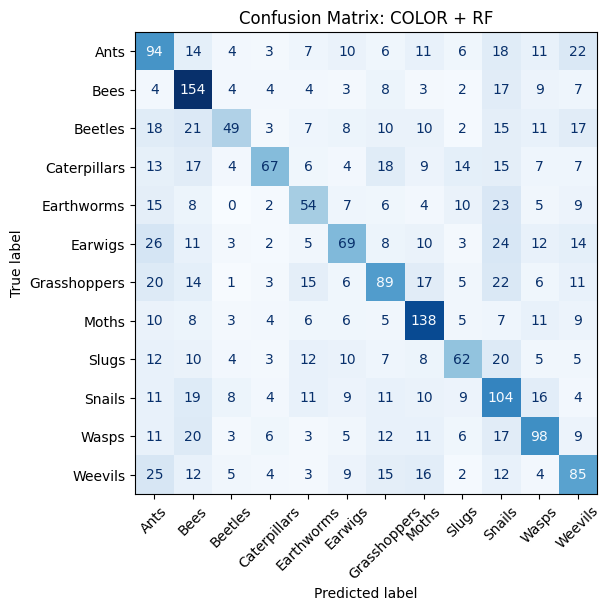


📊 Accuracy=0.463, Precision=0.477, Recall=0.454, F1=0.455


In [15]:
# ## 9️⃣ 结果分析与可视化

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1️⃣ 读取结果表
res = pd.read_csv(os.path.join(RESULT_DIR, "model_comparison_fast.csv"))
best = res.sort_values("f1", ascending=False).iloc[0]
print("🏆 最佳模型:", best["name"])
print(best[["acc", "prec", "rec", "f1", "auc", "time_sec"]])

# 2️⃣ 分析模型名称
feat_type, model_name = best["name"].split("_")

# 3️⃣ 重新准备数据
D = joblib.load(os.path.join(FEATURE_DIR, "features_all.pkl"))
X = D[feat_type]
y = D["y"]
Xtr, Xv, yt, yv = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
sc = StandardScaler()
Xtr_s = sc.fit_transform(Xtr)
Xv_s = sc.transform(Xv)

# 4️⃣ 重新训练最佳模型
if model_name == "SGD":
    clf = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, class_weight='balanced', random_state=RANDOM_STATE)
elif model_name == "RF":
    clf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
else:
    clf = MLPClassifier(hidden_layer_sizes=(128,), max_iter=100, random_state=RANDOM_STATE)

clf.fit(Xtr_s, yt)
y_pred = clf.predict(Xv_s)

# 5️⃣ 绘制混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix(yv, y_pred), display_labels=list(D["idx2label"].values()))
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", colorbar=False)
plt.title(f"Confusion Matrix: {feat_type.upper()} + {model_name}")
plt.show()

# 6️⃣ 打印各类指标平均值
acc = accuracy_score(yv, y_pred)
p, r, f1, _ = precision_recall_fscore_support(yv, y_pred, average='macro')
print(f"\n📊 Accuracy={acc:.3f}, Precision={p:.3f}, Recall={r:.3f}, F1={f1:.3f}")
